# Tutorial 1: Integrating adjacent DLPFC slices
This tutorial demonstrates STAligner's ablility to integrate multiple adjacent slices. The slices are sampled from human dorsolateral prefrontal cortex (DLPFC) and the processed data can be downloaded from https://drive.google.com/drive/folders/1pHJy2cB9BKqc3ny9IpvVhiw_8ukJMzPW?usp=share_link.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import ST_utils
# import train_STAligner
import STAligner

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "/users/jyao/.conda/envs/proust-310/lib/R"
os.environ['R_USER'] = "/users/jyao/.conda/envs/STAligner/lib/python3.9/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg

import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data

In [3]:
Batch_list = []
adj_list = []
section_ids = ['151673','151674','151675','151676']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = '/dcs04/hicks/data/jianing/datasets/proust_datasets/spatialDLPFC/' + str(section_id)
    adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    df_meta = pd.read_csv(input_dir + '/metadata.tsv', sep='\t')
    df_meta_layer = df_meta['layer_guess']
    adata.obs['ground_truth'] = df_meta_layer.values
    adata.obs['ground_truth'] = adata.obs['ground_truth'].astype('category')
    
    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]
    
    # Constructing the spatial network
    STAligner.Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
    
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151673', '151674', '151675', '151676']
151673
------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
151674
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.
151675
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
151676
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


## Concat the scanpy objects for multiple slices

In [4]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['ground_truth'] = adata_concat.obs['ground_truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (14364, 1125)


## Concat the spatial network for multiple slices

In [5]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

## Running STAligner

In [6]:
%%time
adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)

STAligner(
  (conv1): GATConv(1125, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 1125, heads=1)
)
Pretrain with STAGATE...


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 56.90it/s]


Train with STAligner...


  0%|                                                                                        | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 19%|███████████████                                                                | 95/500 [00:10<00:08, 50.13it/s]

Update spot triplets at epoch 600


 39%|██████████████████████████████▋                                               | 197/500 [00:21<00:06, 49.76it/s]

Update spot triplets at epoch 700


 60%|██████████████████████████████████████████████▋                               | 299/500 [00:32<00:04, 49.82it/s]

Update spot triplets at epoch 800


 79%|█████████████████████████████████████████████████████████████▌                | 395/500 [00:43<00:02, 48.18it/s]

Update spot triplets at epoch 900


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:54<00:00,  9.19it/s]

CPU times: user 1min 9s, sys: 4.63 s, total: 1min 14s
Wall time: 1min 3s


## Clustering

In [8]:
STAligner.mclust_R(adata_concat, num_cluster=7, used_obsm='STAligner')
adata_concat = adata_concat[~pd.isnull(adata_concat.obs['ground_truth'])]

from sklearn.metrics import adjusted_rand_score as ari_score
print('mclust, ARI = %01.3f' % ari_score(adata_concat.obs['ground_truth'], adata_concat.obs['mclust']))

fitting ...
  |======================================================================| 100%
mclust, ARI = 0.565


## Visualization

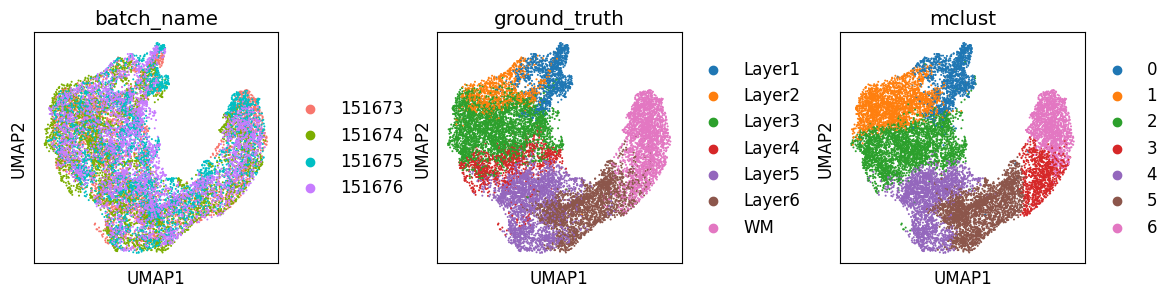

In [9]:
import logging
import matplotlib.font_manager

# Set the font manager logger to suppress findfont warnings
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(section_ids, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]
adata_concat.obs['mclust'] = pd.Series(STAligner.match_cluster_labels(adata_concat.obs['ground_truth'], adata_concat.obs['mclust'].values),
                                         index=adata_concat.obs.index, dtype='category')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata_concat, color=['batch_name', 'ground_truth', 'mclust'], ncols=3, 
           wspace=0.5, show=True)

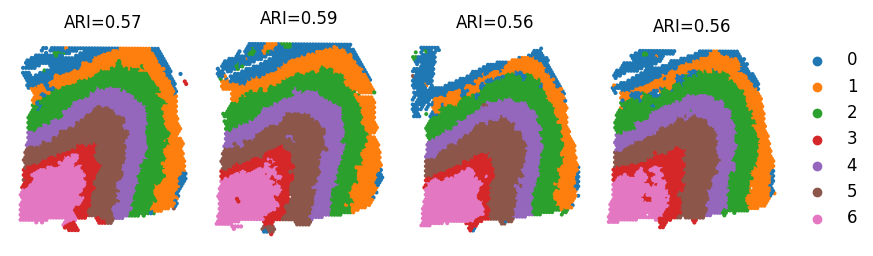

In [10]:
Batch_list = []
for section_id in section_ids:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['ground_truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['mclust'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
plt.show()